In [1]:
%matplotlib inline
%pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import squidpy as sq
from STEM.evaluate import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def rotate(points, origin, angle): 
    # 将角度从度数转换为弧度 
    angle = np.radians(angle) 
    # 计算旋转矩阵 
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]) 
    # 将点数组减去原点 
    points = points - origin 
    # 用旋转矩阵乘以点数组 
    points = np.dot(points, rotation_matrix) 
    # 将点数组加上原点 
    points = points + origin 
    # 返回旋转后的点数组 
    return points

In [3]:
scdata = pd.read_csv('./data/MERFISH/human_MTG_2018-06-14_exon-matrix_selected.csv')
scmetadata = pd.read_csv('./data/MERFISH/human_MTG_2018-06-14_samples-columns.csv',index_col=0)
scgenes = pd.read_csv('./data/MERFISH/human_MTG_2018-06-14_genes-rows_selected.csv')

scadata = sc.AnnData(scdata)
scadata.var_names = scgenes.gene.values

stgtcelltype = pd.read_csv('./data/cortical_2022/donor1_rep3_new/simu_st_celltype.csv',index_col=0)
stcoor = pd.read_csv('./data/cortical_2022/donor1_rep3_new/metadata.csv',index_col=0)
stcoor = stcoor.rename(columns={'x_global': 'coord_x','y_global': 'coord_y'})

stmetadata = pd.read_csv('./data/cortical_2022/donor1_rep3_new/metadata.csv',index_col=0)
stdata = pd.read_csv('./data/cortical_2022/donor1_rep3_new/counts.csv',index_col=0).T

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
scadata.obs = scmetadata
scadata.obs['cluster_sub'] = [cluster.split(' ')[0]+' '+cluster.split(' ')[1] for cluster in scadata.obs['cluster'].values]

In [5]:
celltypelist=stgtcelltype.columns[((stgtcelltype>0.2).sum(0)>20)].tolist()
print(celltypelist)

['EXC', 'INC', 'lASC', 'lMGC', 'lOGC', 'lOPC', 'oENDO', 'oMURAL']


In [6]:
rotated_array = rotate(stmetadata[['x_global','y_global']].values, (0,0), 10)
rotated_array[:,0] = rotated_array[:,0]-rotated_array[:,0].min()
cell_region=[]
for i in range(rotated_array.shape[0]):
    if rotated_array[i][0]<1300:
        cell_region.append("L1")
    elif rotated_array[i][0]<3200:
        cell_region.append("L2/3")
    elif rotated_array[i][0]<4300:
        cell_region.append("L4")
    elif rotated_array[i][0]<5600:
        cell_region.append("L5")
    # elif rotated_array[i][0]<7000:
    #     cell_region.append("L6")
    else:
        cell_region.append("L6 and others")

stmetadata["region"]=np.array(cell_region)

In [7]:
sc.settings.figdir = './result_cortical/'

In [8]:
stadata = sc.AnnData(stdata)
stadata.obs = stmetadata

stadata.obs['cluster'] = stadata.obs['region'].astype('category')
stadata.obsm['spatial'] = np.concatenate((np.expand_dims(stadata.obs['x_global'],axis=-1),np.expand_dims(stadata.obs['y_global'],axis=-1)),axis=-1)

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cluster_L1' as categorical
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cluster_L2' as categorical
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future

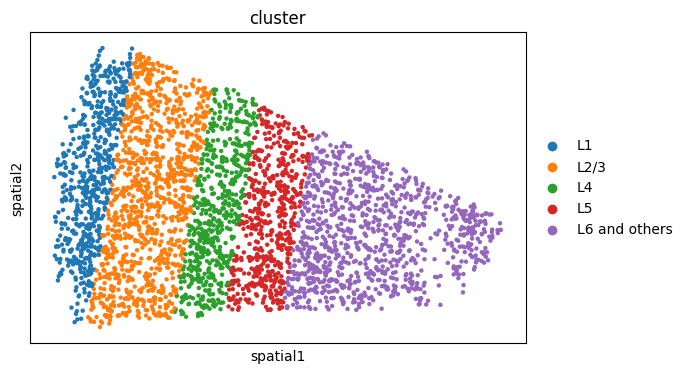

In [9]:
sc.pl.spatial(stadata,spot_size=100,color=['cluster'])

# Spaotsc

In [10]:
spaotsc_mappingmtx = pd.read_csv('./result/spaotsc/cortical_donor1_rep3_new/mapping-ori.csv',index_col=0)

smartseq+merfish evaluation

In [11]:
scpred_coord = all_coord(spaotsc_mappingmtx,stcoor)
scadata.obsm['spatial'] = scpred_coord

In [12]:
rotated_array = rotate(scadata.obsm['spatial'], (0,0), 10)

In [13]:
distance_spaotsc = pd.DataFrame(columns=["dis","method","region"])
for i in range(rotated_array.shape[0]):
    distance_spaotsc.loc[len(distance_spaotsc.index)] = [rotated_array[i][0],"Spaotsc", scadata.obs['brain_subregion'][i]]

In [14]:
scadata.obsm['spatial'] = rotated_array
tmp_adata1 = scadata[['Exc' in c for c in scadata.obs['cluster_sub']],:].copy()
tmp_adata1.obs['cluster_new'] = 'Exc' + tmp_adata1.obs['brain_subregion'].astype('object')

tmp_adata2 = stadata[['L' in c for c in stadata.obs['cluster']],:]
tmp_adata2.obs['cluster_new'] = [cluster.split('.')[0] for cluster in tmp_adata2.obs['cluster']]

tmp_adata = sc.AnnData.concatenate(tmp_adata1, tmp_adata2)
tmp_adata.obs['cluster_new'] = tmp_adata.obs['cluster_new'].astype('category')

sq.gr.spatial_neighbors(tmp_adata)
sq.gr.nhood_enrichment(tmp_adata, cluster_key="cluster_new")

Trying to set attribute `.obs` of view, copying.


  0%|          | 0/1000 [00:00<?, ?/s]

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample_type' as categorical
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'organism' as categorical
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future 

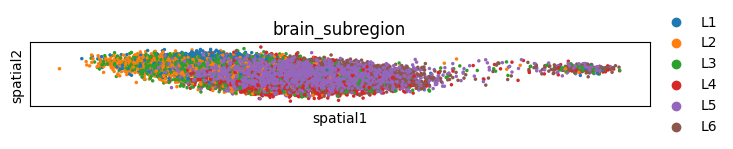

In [15]:
figsize(8,10)
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
sc.pl.spatial(scadata,spot_size=10,basis='spatial',color='brain_subregion')

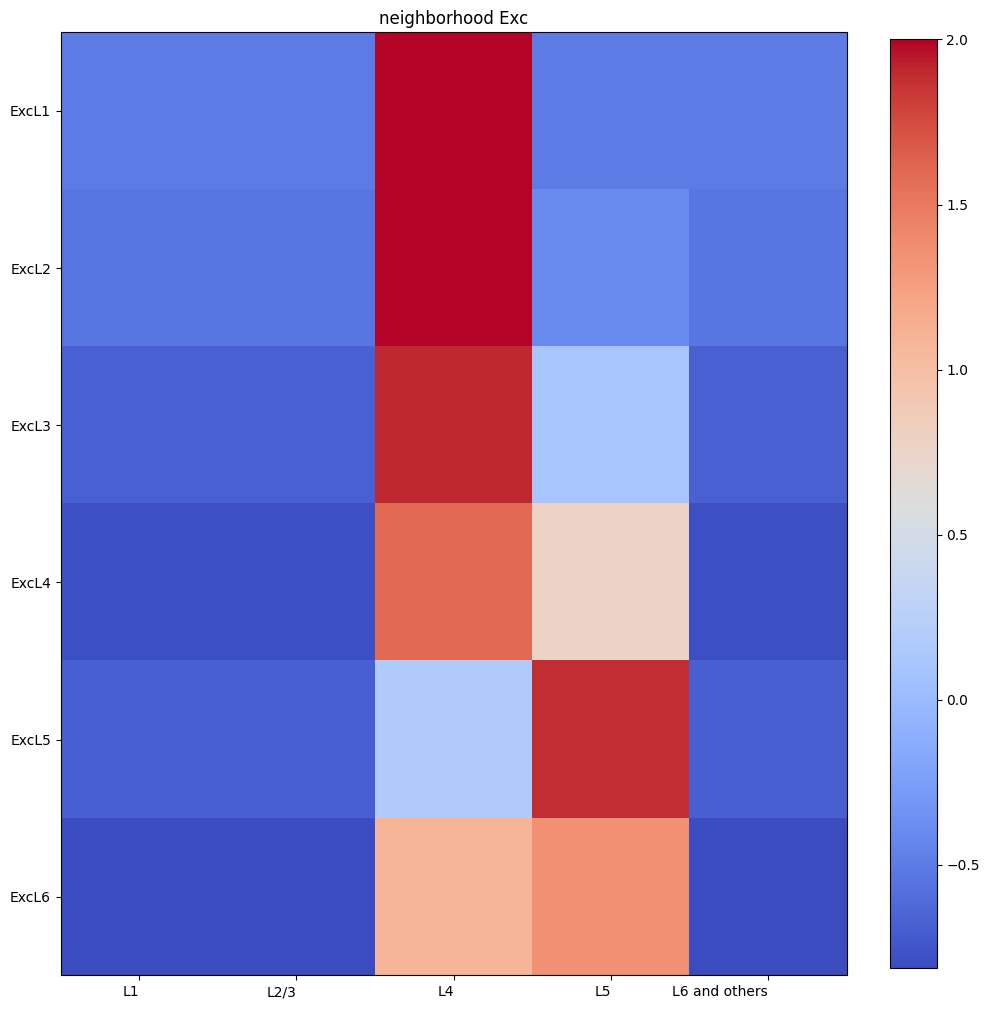

In [16]:
scclass = np.sort(tmp_adata.obs['cluster_new'].unique())[:6]
stclass = np.sort(tmp_adata.obs['cluster_new'].unique())[6:]

zscore = tmp_adata.uns['cluster_new_nhood_enrichment']['count'][:6,6:].astype(float)
for i in range(zscore.shape[0]):
    zscore[i] = (zscore[i]-zscore[i].mean())/(zscore[i].std())

figsize(10,12)
    
plt.xticks(np.arange(len(stclass)), labels=stclass, 
                     rotation_mode="anchor", ha="right")
plt.yticks(np.arange(len(scclass)), labels=scclass)    
plt.title("neighborhood Exc")

im = plt.imshow(zscore,cmap='coolwarm')
plt.colorbar(im,fraction=0.053)
plt.tight_layout()
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# plt.savefig('nipsfig_cortical/Spaotsc_Exc_neighborhoood.pdf',bbox_inches='tight')

end here

# DA

算celltype的时候 要选st2sc的矩阵，也就是stmapping到所有sc为1

计算单细胞空间坐标时，要用sc2st的矩阵，也就是scmapping到所有sc为1

计算单细胞近邻时，可以直接用embedding向量

In [17]:
da_result=[]
st_index = pd.read_csv('./data/cortical_2022/donor1_rep3_new/simu_st_counts.csv',index_col=0)
da_mappingmtx = np.load('./result/230215_testdp_pure_mmd-cortical-donor1_rep3+smartseq.npy').T
da_mappingmtx = pd.DataFrame(da_mappingmtx,index = scdata.index, columns=st_index.columns)

scmetadatasmartseq+merfish evaluation

cluster sub是具体的类型，cluster是layer，cluster new=cluster

In [18]:
simu_stcoor = pd.read_csv('./data/cortical_2022/donor1_rep3_new/simu_st_metadata.csv',index_col=0)
scpred_coord = all_coord(da_mappingmtx,simu_stcoor)
scadata.obsm['spatial'] = scpred_coord

In [19]:
rotated_array = rotate(scadata.obsm['spatial'], (0,0), 10)

In [20]:
distance_ours = pd.DataFrame(columns=["dis","method","region"])
for i in range(rotated_array.shape[0]):
    distance_ours.loc[len(distance_ours.index)] = [rotated_array[i][0],"Ours", scadata.obs['brain_subregion'][i]]

In [21]:
scadata.obsm['spatial'] = rotated_array
tmp_adata1 = scadata[['Exc' in c for c in scadata.obs['cluster_sub']],:].copy()
tmp_adata1.obs['cluster_new'] = "Exc "+ tmp_adata1.obs['brain_subregion'].astype('object')

tmp_adata2 = stadata[['L' in c for c in stadata.obs['cluster']],:]
tmp_adata2.obs['cluster_new'] = [cluster.split('.')[0] for cluster in tmp_adata2.obs['cluster']]

tmp_adata = sc.AnnData.concatenate(tmp_adata1, tmp_adata2)
tmp_adata.obs['cluster_new'] = tmp_adata.obs['cluster_new'].astype('category')

sq.gr.spatial_neighbors(tmp_adata)
sq.gr.nhood_enrichment(tmp_adata, cluster_key="cluster_new")

Trying to set attribute `.obs` of view, copying.


  0%|          | 0/1000 [00:00<?, ?/s]

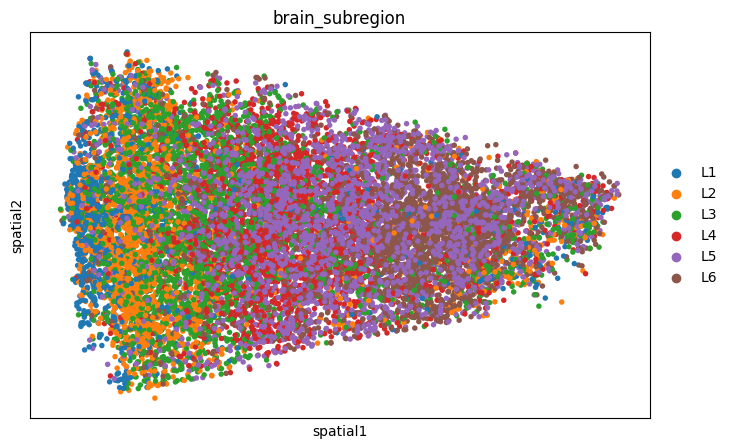

In [22]:
figsize(8,10)
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
sc.pl.spatial(scadata,spot_size=100,basis='spatial',color='brain_subregion')

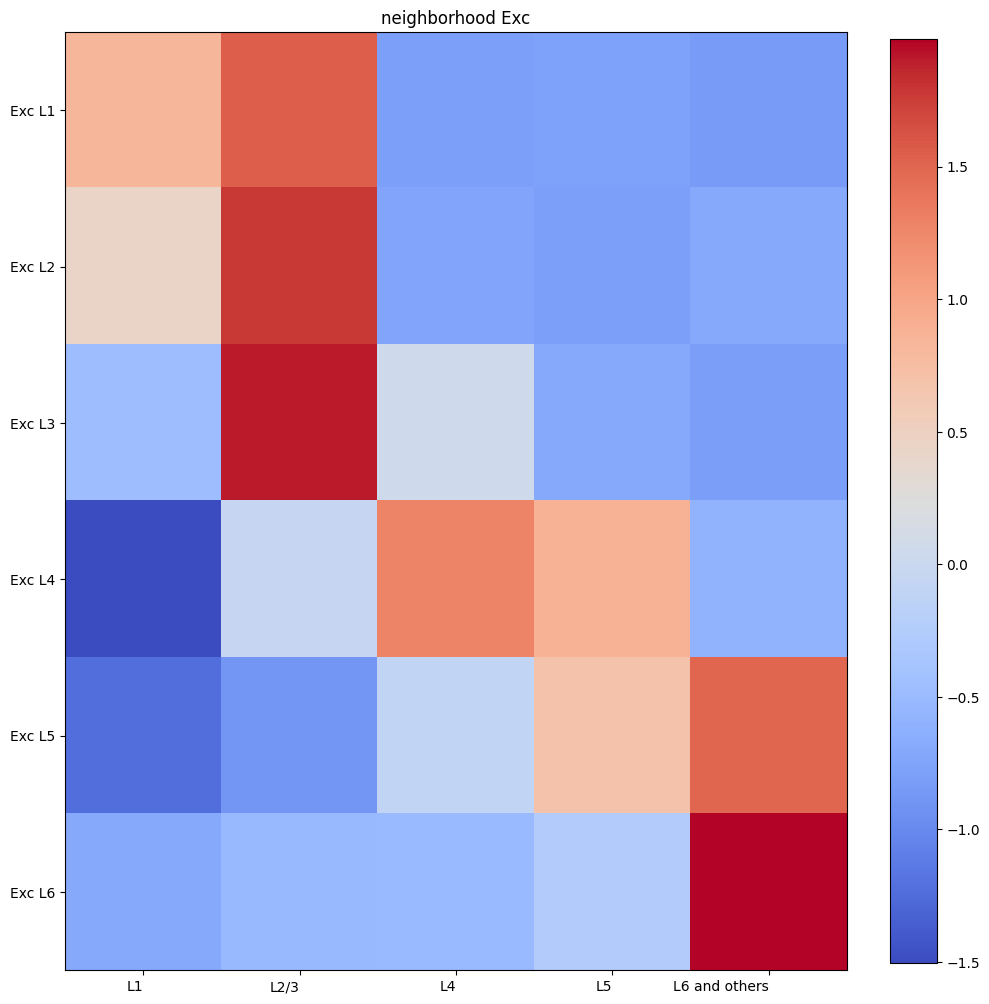

In [24]:
scclass = np.sort(tmp_adata.obs['cluster_new'].unique())[:6]
stclass = np.sort(tmp_adata.obs['cluster_new'].unique())[6:]

zscore = tmp_adata.uns['cluster_new_nhood_enrichment']['count'][:6,6:].astype(float)
for i in range(zscore.shape[0]):
    # zscore[i] = (zscore[i]-zscore[i].min())/(zscore[i].max()-zscore[i].min())
    zscore[i] = (zscore[i]-zscore[i].mean())/(zscore[i].std())
# zscore = np.stack([(count-count.mean())/count.std() for count in tmp_adata.uns['cluster_new_nhood_enrichment']['count'][:6,6:]])

figsize(10,12)
    
plt.xticks(np.arange(len(stclass)), labels=stclass, 
                     rotation_mode="anchor", ha="right")
plt.yticks(np.arange(len(scclass)), labels=scclass)    
plt.title("neighborhood Exc")

# for i in range(len(scclass)):
#     for j in range(len(stclass)):
#         text = plt.text(j, i, zscore[i, j], ha="center", va="center", color="w")

im = plt.imshow(zscore,cmap='coolwarm')
plt.colorbar(im,fraction=0.053)
plt.tight_layout()
# plt.show()
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# plt.savefig('nipsfig_cortical/Ours_Exc_neighborhoood.pdf',bbox_inches='tight')

# Tangram

In [25]:
tg_mappingmtx = np.load('./result/tangram/cortical_donor1_rep3_new-ori.npy')
tg_mappingmtx = pd.DataFrame(tg_mappingmtx,index = scdata.index, columns=stdata.index)

In [26]:
scpred_coord = all_coord(tg_mappingmtx,stcoor)

smartseq+merfish evaluation

In [27]:
scadata.obsm['spatial'] = scpred_coord

In [28]:
rotated_array = rotate(scadata.obsm['spatial'], (0,0), 10)

In [29]:
distance_tangram = pd.DataFrame(columns=["dis","method","region"])
for i in range(rotated_array.shape[0]):
    distance_tangram.loc[len(distance_tangram.index)] = [rotated_array[i][0],"Tangram", scadata.obs['brain_subregion'][i]]

In [30]:
scadata.obsm['spatial'] = rotated_array
tmp_adata1 = scadata[['Exc' in c for c in scadata.obs['cluster_sub']],:].copy()
tmp_adata1.obs['cluster_new'] = 'Exc' + tmp_adata1.obs['brain_subregion'].astype('object')

tmp_adata2 = stadata[['L' in c for c in stadata.obs['cluster']],:]
tmp_adata2.obs['cluster_new'] = [cluster.split('.')[0] for cluster in tmp_adata2.obs['cluster']]

tmp_adata = sc.AnnData.concatenate(tmp_adata1, tmp_adata2)
tmp_adata.obs['cluster_new'] = tmp_adata.obs['cluster_new'].astype('category')

sq.gr.spatial_neighbors(tmp_adata)
sq.gr.nhood_enrichment(tmp_adata, cluster_key="cluster_new")

Trying to set attribute `.obs` of view, copying.


  0%|          | 0/1000 [00:00<?, ?/s]

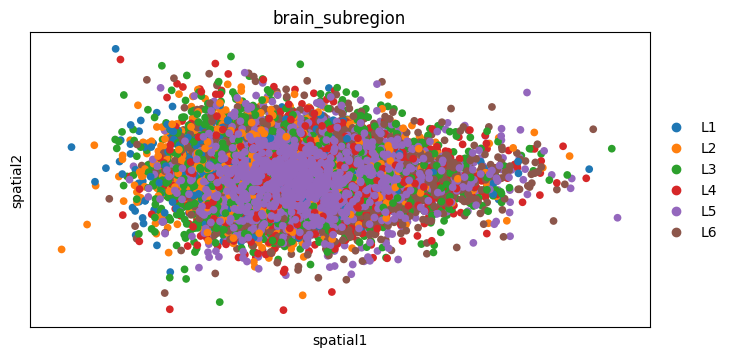

In [31]:
figsize(8,10)
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
sc.pl.spatial(scadata,spot_size=100,basis='spatial',color='brain_subregion')

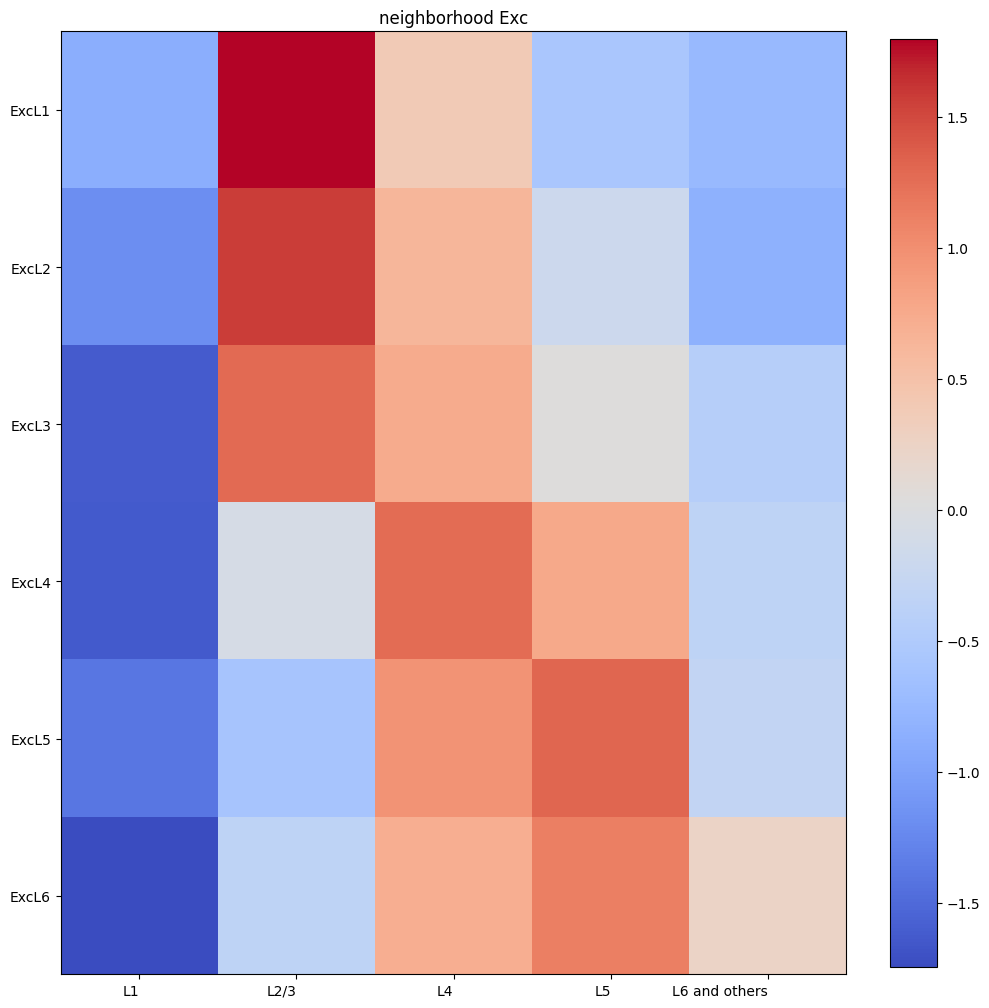

In [32]:
scclass = np.sort(tmp_adata.obs['cluster_new'].unique())[:6]
stclass = np.sort(tmp_adata.obs['cluster_new'].unique())[6:]

zscore = tmp_adata.uns['cluster_new_nhood_enrichment']['count'][:6,6:].astype(float)
for i in range(zscore.shape[0]):
    zscore[i] = (zscore[i]-zscore[i].mean())/(zscore[i].std())

figsize(10,12)
    
plt.xticks(np.arange(len(stclass)), labels=stclass, 
                     rotation_mode="anchor", ha="right")
plt.yticks(np.arange(len(scclass)), labels=scclass)    
plt.title("neighborhood Exc")

im = plt.imshow(zscore,cmap='coolwarm')
plt.colorbar(im,fraction=0.053)
plt.tight_layout()
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# plt.savefig('nipsfig_cortical/Tangram_Inh_neighborhoood.pdf',bbox_inches='tight')

end here

# CellTrek

In [33]:
def evaluation_coord(celltrekdf,stcoor,stgtcelltype):
    celltrek_celltype = pd.get_dummies(celltrekdf.cell_type)
    xy_coord = celltrekdf[['coord_x','coord_y']].values 
    from tqdm import tqdm
    st_anno = np.zeros([stcoor.shape[0],celltrek_celltype.shape[1]])
    xbin,ybin = 5.419293802859556, 5.550054857803843
    for i in tqdm(range(stcoor.shape[0])):
        xbmin = stcoor.values[i][0]-xbin/100*55/2
        xbmax = stcoor.values[i][0]+xbin/100*55/2
        ybmin = stcoor.values[i][1]-ybin/100*55/2
        ybmax = stcoor.values[i][1]+ybin/100*55/2
        for x in range(xy_coord.shape[0]):
            if xy_coord[x][0]>xbmin and xy_coord[x][0]<=xbmax and xy_coord[x][1]>ybmin and xy_coord[x][1]<=ybmax:
                st_anno[i]+=celltrek_celltype.values[x]

    stannodf = pd.DataFrame(st_anno,columns=celltrek_celltype.columns)
    stannodf.index = stcoor.index
    stannodf = stannodf.div(stannodf.sum(1),0)
    stannodf = stannodf.fillna(0)

    pr_celltrek=[]
    for i in range(stgtcelltype.shape[1]):
        pearson = scipy.stats.pearsonr(stgtcelltype.iloc[:,i],stannodf[stgtcelltype.columns[i]])[0]  
        if np.isnan(pearson):
            pearson=0
        pr_celltrek.append(pearson)
    pr_celltrek = pd.DataFrame(pr_celltrek,index=stgtcelltype.columns).T

    kl_celltrek=[]
    for i in range(stgtcelltype.shape[1]):
        scl =  stannodf[stgtcelltype.columns[i]]
        klscore = scipy.special.kl_div(stgtcelltype.iloc[:,i]/stgtcelltype.iloc[:,i].sum(),scl.values/ scl.values.sum()+1e-15).sum()
        kl_celltrek.append(klscore)
    kl_celltrek = pd.DataFrame(kl_celltrek,index=stgtcelltype.columns).T
    

In [34]:
celltrekdf = pd.read_csv('./result/celltrek/cortical_donor1_rep3/xycelltype_ori.csv',index_col=0)

In [35]:
celltrek_celltype = pd.get_dummies(celltrekdf.cell_type)

xy_coord = celltrekdf[['x_global','y_global']].values

In [36]:
region = np.array([scmetadata.loc[name.split('.')[0], "brain_subregion"] for name in celltrekdf.index])

pd.DataFrame(celltrekdf.cell_type)smartseq+merfish evaluation

In [37]:
scadata_celltrek = scadata[:xy_coord.shape[0],:]

scadata_celltrek.obs = pd.DataFrame(celltrekdf.cell_type)
scadata_celltrek.obsm['spatial'] = xy_coord

scadata_celltrek.obs['cluster_sub'] = [cluster.split(' ')[0]+' '+cluster.split(' ')[1] for cluster in scadata_celltrek.obs['cell_type']]
scadata_celltrek.obs['brain_subregion']= region

In [38]:
rotated_array = rotate(scadata_celltrek.obsm['spatial'], (0,0), 10)

In [39]:
distance_celltrek = pd.DataFrame(columns=["dis","method","region"])
for i in range(rotated_array.shape[0]):
    distance_celltrek.loc[len(distance_celltrek.index)] = [rotated_array[i][0],"Celltrek", scadata.obs['brain_subregion'][i]]

In [40]:
scadata_celltrek.obsm['spatial'] = rotated_array
tmp_adata1 = scadata_celltrek[['Exc' in c for c in scadata_celltrek.obs['cluster_sub']],:].copy()
tmp_adata1.obs['cluster_new'] = 'Exc' + tmp_adata1.obs['brain_subregion'].astype('object')

tmp_adata2 = stadata[['L' in c for c in stadata.obs['cluster']],:]
tmp_adata2.obs['cluster_new'] = [cluster.split('.')[0] for cluster in tmp_adata2.obs['cluster']]

tmp_adata = sc.AnnData.concatenate(tmp_adata1, tmp_adata2)
tmp_adata.obs['cluster_new'] = tmp_adata.obs['cluster_new'].astype('category')

sq.gr.spatial_neighbors(tmp_adata)
sq.gr.nhood_enrichment(tmp_adata, cluster_key="cluster_new")

Trying to set attribute `.obs` of view, copying.


  0%|          | 0/1000 [00:00<?, ?/s]

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cluster_sub' as categorical
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future

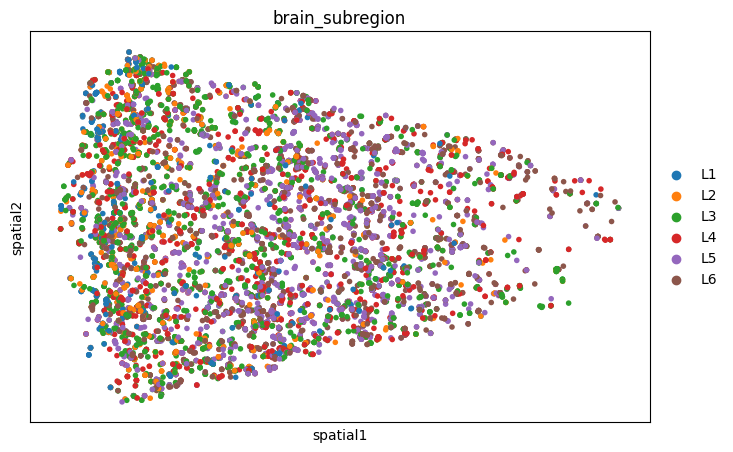

In [41]:
figsize(8,10)
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
sc.pl.spatial(scadata_celltrek,spot_size=100,basis='spatial',color='brain_subregion')

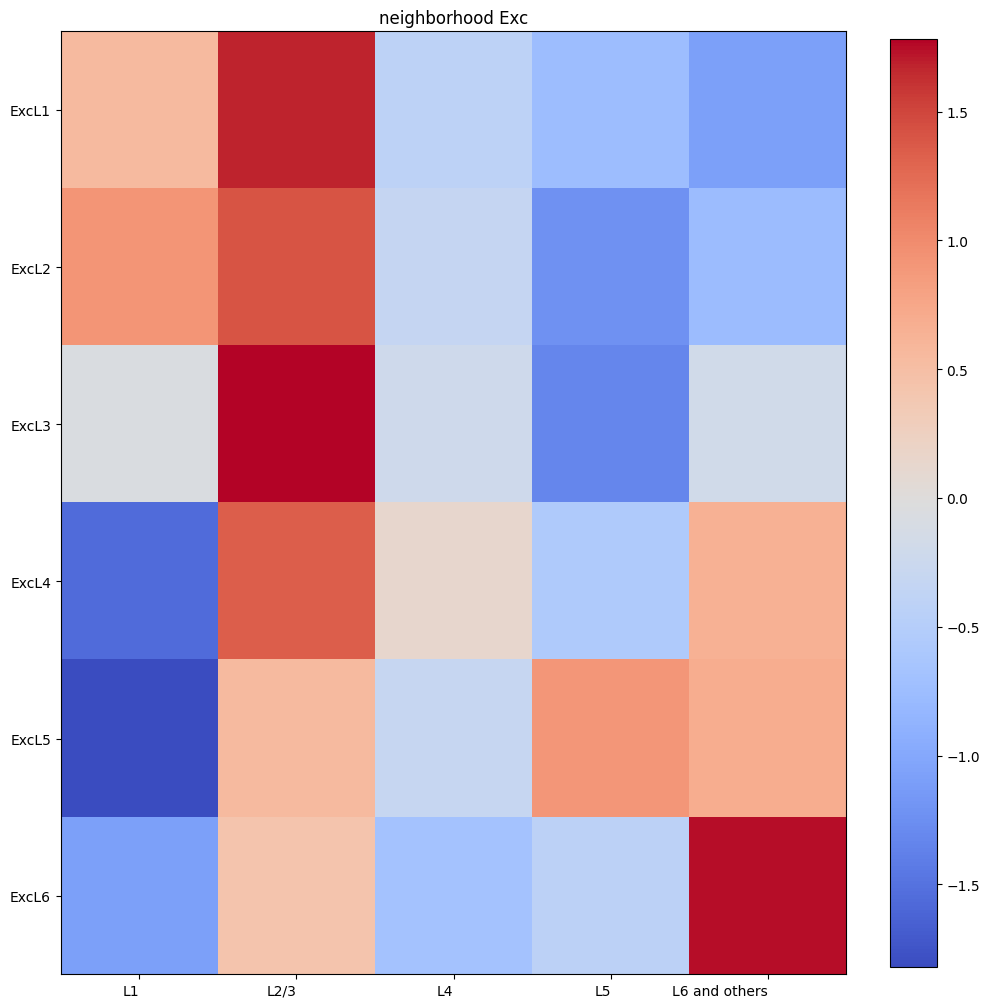

In [42]:
scclass = np.sort(tmp_adata.obs['cluster_new'].unique())[:6]
stclass = np.sort(tmp_adata.obs['cluster_new'].unique())[6:]

zscore = tmp_adata.uns['cluster_new_nhood_enrichment']['count'][:6,6:].astype(float)
for i in range(zscore.shape[0]):
    zscore[i] = (zscore[i]-zscore[i].mean())/(zscore[i].std())

figsize(10,12)
    
plt.xticks(np.arange(len(stclass)), labels=stclass, 
                     rotation_mode="anchor", ha="right")
plt.yticks(np.arange(len(scclass)), labels=scclass)    
plt.title("neighborhood Exc")

im = plt.imshow(zscore,cmap='coolwarm')
plt.colorbar(im,fraction=0.053)
plt.tight_layout()
# plt.show()
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# plt.savefig('nipsfig_cortical/Celltrek_Exc_neighborhoood.pdf',bbox_inches='tight')

end here

# Seurat

In [43]:
seurat_mappingmtx = pd.read_csv('./result/seurat/cortical-rep3-ori_mapping.csv',index_col=0).T
seurat_mappingmtx.columns = stdata.index

smartseq+merfish evaluation

In [44]:
scpred_coord = all_coord(seurat_mappingmtx,stcoor)
scadata.obsm['spatial'] = scpred_coord

In [45]:
rotated_array = rotate(scadata.obsm['spatial'], (0,0), 10)

In [46]:
distance_seurat = pd.DataFrame(columns=["dis","method","region"])
for i in range(rotated_array.shape[0]):
    distance_seurat.loc[len(distance_seurat.index)] = [rotated_array[i][0],"Seurat", scadata.obs['brain_subregion'][i]]

In [47]:
scadata.obsm['spatial'] = rotated_array
tmp_adata1 = scadata[['Exc' in c for c in scadata.obs['cluster_sub']],:].copy()
tmp_adata1.obs['cluster_new'] = 'Exc' + tmp_adata1.obs['brain_subregion'].astype('object')

tmp_adata2 = stadata[['L' in c for c in stadata.obs['cluster']],:]
tmp_adata2.obs['cluster_new'] = [cluster.split('.')[0] for cluster in tmp_adata2.obs['cluster']]

tmp_adata = sc.AnnData.concatenate(tmp_adata1, tmp_adata2)
tmp_adata.obs['cluster_new'] = tmp_adata.obs['cluster_new'].astype('category')

sq.gr.spatial_neighbors(tmp_adata)
sq.gr.nhood_enrichment(tmp_adata, cluster_key="cluster_new")

Trying to set attribute `.obs` of view, copying.


  0%|          | 0/1000 [00:00<?, ?/s]

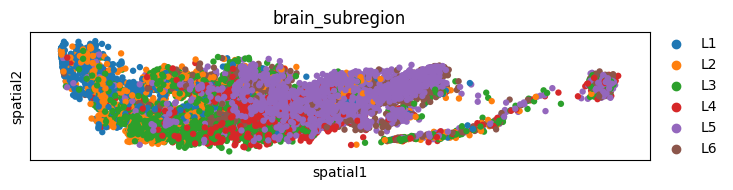

In [48]:
figsize(8,10)
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
sc.pl.spatial(scadata,spot_size=100,basis='spatial',color='brain_subregion')

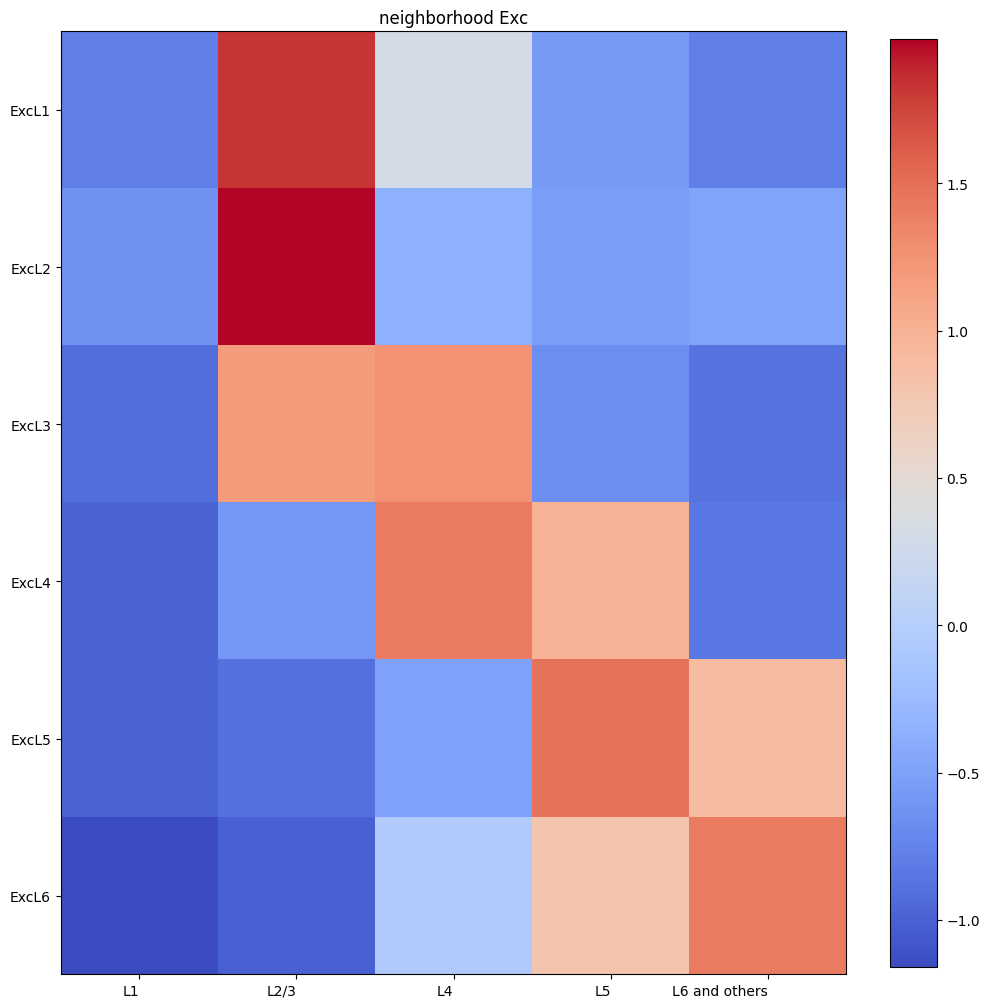

In [49]:
scclass = np.sort(tmp_adata.obs['cluster_new'].unique())[:6]
stclass = np.sort(tmp_adata.obs['cluster_new'].unique())[6:]

zscore = tmp_adata.uns['cluster_new_nhood_enrichment']['count'][:6,6:].astype(float)
for i in range(zscore.shape[0]):
    zscore[i] = (zscore[i]-zscore[i].mean())/(zscore[i].std())

figsize(10,12)
    
plt.xticks(np.arange(len(stclass)), labels=stclass, 
                     rotation_mode="anchor", ha="right")
plt.yticks(np.arange(len(scclass)), labels=scclass)    
plt.title("neighborhood Exc")

im = plt.imshow(zscore,cmap='coolwarm')
plt.colorbar(im,fraction=0.053)
plt.tight_layout()
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# plt.savefig('nipsfig_cortical/Seurat_Exc_neighborhoood.pdf',bbox_inches='tight')

end here

# scSpace

In [50]:
scspacedf = pd.read_csv('./result/scspace/scspace_pseudo_space_cortical-rep3-ori.csv',index_col=0)

In [51]:
scspacedf.index = scmetadata.index
scspacedf.columns = ['coord_x','coord_y']

In [52]:
scspacedf['cell_type'] = scmetadata.cluster

In [53]:
scspacedf_celltype = pd.get_dummies(scspacedf.cell_type)

In [54]:
xy_coord = scspacedf[['coord_x','coord_y']].values

smartseq+merfish evaluation

In [55]:
scadata.obsm['spatial'] = xy_coord

In [56]:
rotated_array = rotate(scadata.obsm['spatial'], (0,0), 10)

In [57]:
distance_scspace = pd.DataFrame(columns=["dis","method","region"])
for i in range(rotated_array.shape[0]):
    distance_scspace.loc[len(distance_scspace.index)] = [rotated_array[i][0],"Scspace", scadata.obs['brain_subregion'][i]]

In [58]:
scadata.obsm['spatial'] = rotated_array
tmp_adata1 = scadata[['Exc' in c for c in scadata.obs['cluster_sub']],:].copy()
tmp_adata1.obs['cluster_new'] = 'Exc' + tmp_adata1.obs['brain_subregion'].astype('object')

tmp_adata2 = stadata[['L' in c for c in stadata.obs['cluster']],:]
tmp_adata2.obs['cluster_new'] = [cluster.split('.')[0] for cluster in tmp_adata2.obs['cluster']]

tmp_adata = sc.AnnData.concatenate(tmp_adata1, tmp_adata2)
tmp_adata.obs['cluster_new'] = tmp_adata.obs['cluster_new'].astype('category')

sq.gr.spatial_neighbors(tmp_adata)
sq.gr.nhood_enrichment(tmp_adata, cluster_key="cluster_new")

Trying to set attribute `.obs` of view, copying.


  0%|          | 0/1000 [00:00<?, ?/s]

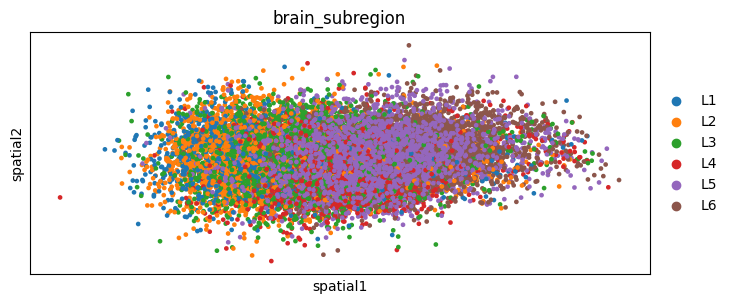

In [59]:
figsize(8,10)
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
sc.pl.spatial(scadata,spot_size=100,basis='spatial',color='brain_subregion')

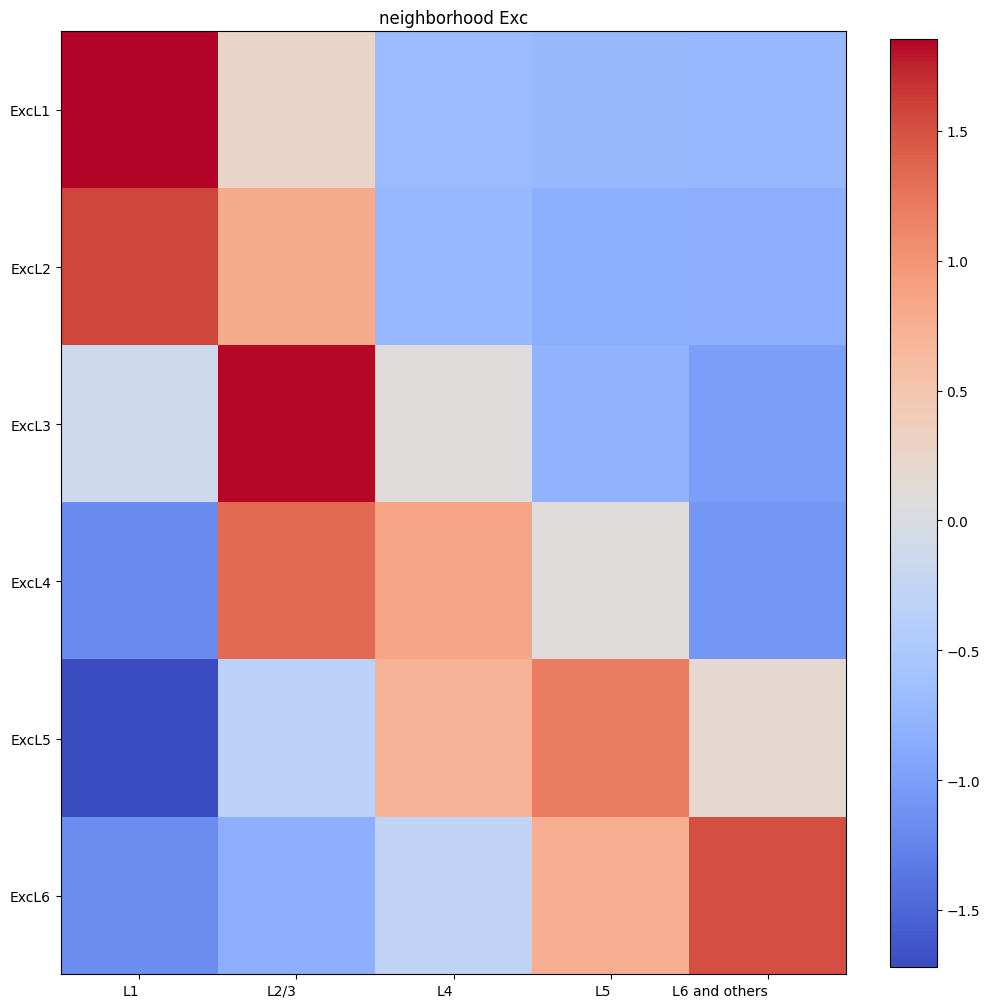

In [60]:
scclass = np.sort(tmp_adata.obs['cluster_new'].unique())[:6]
stclass = np.sort(tmp_adata.obs['cluster_new'].unique())[6:]

zscore = tmp_adata.uns['cluster_new_nhood_enrichment']['count'][:6,6:].astype(float)
for i in range(zscore.shape[0]):
    zscore[i] = (zscore[i]-zscore[i].mean())/(zscore[i].std())

figsize(10,12)
    
plt.xticks(np.arange(len(stclass)), labels=stclass, 
                     rotation_mode="anchor", ha="right")
plt.yticks(np.arange(len(scclass)), labels=scclass)    
plt.title("neighborhood Exc")

im = plt.imshow(zscore,cmap='coolwarm')
plt.colorbar(im,fraction=0.053)
plt.tight_layout()
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# plt.savefig('nipsfig_cortical/Scspace_Exc_neighborhoood.pdf',bbox_inches='tight')

end here

# Result

In [61]:
distance_spaotsc['dis']=distance_spaotsc['dis']-distance_spaotsc['dis'].min()
distance_ours['dis']=distance_ours['dis']-distance_ours['dis'].min()
distance_tangram['dis']=distance_tangram['dis']-distance_tangram['dis'].min()
distance_celltrek['dis']=distance_celltrek['dis']-distance_celltrek['dis'].min()
distance_seurat['dis']=distance_seurat['dis']-distance_seurat['dis'].min()
distance_scspace['dis']=distance_scspace['dis']-distance_scspace['dis'].min()

In [62]:
dis_boxplot = pd.concat([distance_spaotsc, distance_ours, distance_tangram, distance_celltrek, distance_seurat, distance_scspace], ignore_index=True)

In [65]:
import colorbm as cbm

In [66]:
sns.set_palette(sns.color_palette(cbm.pal('npg').as_hex))

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

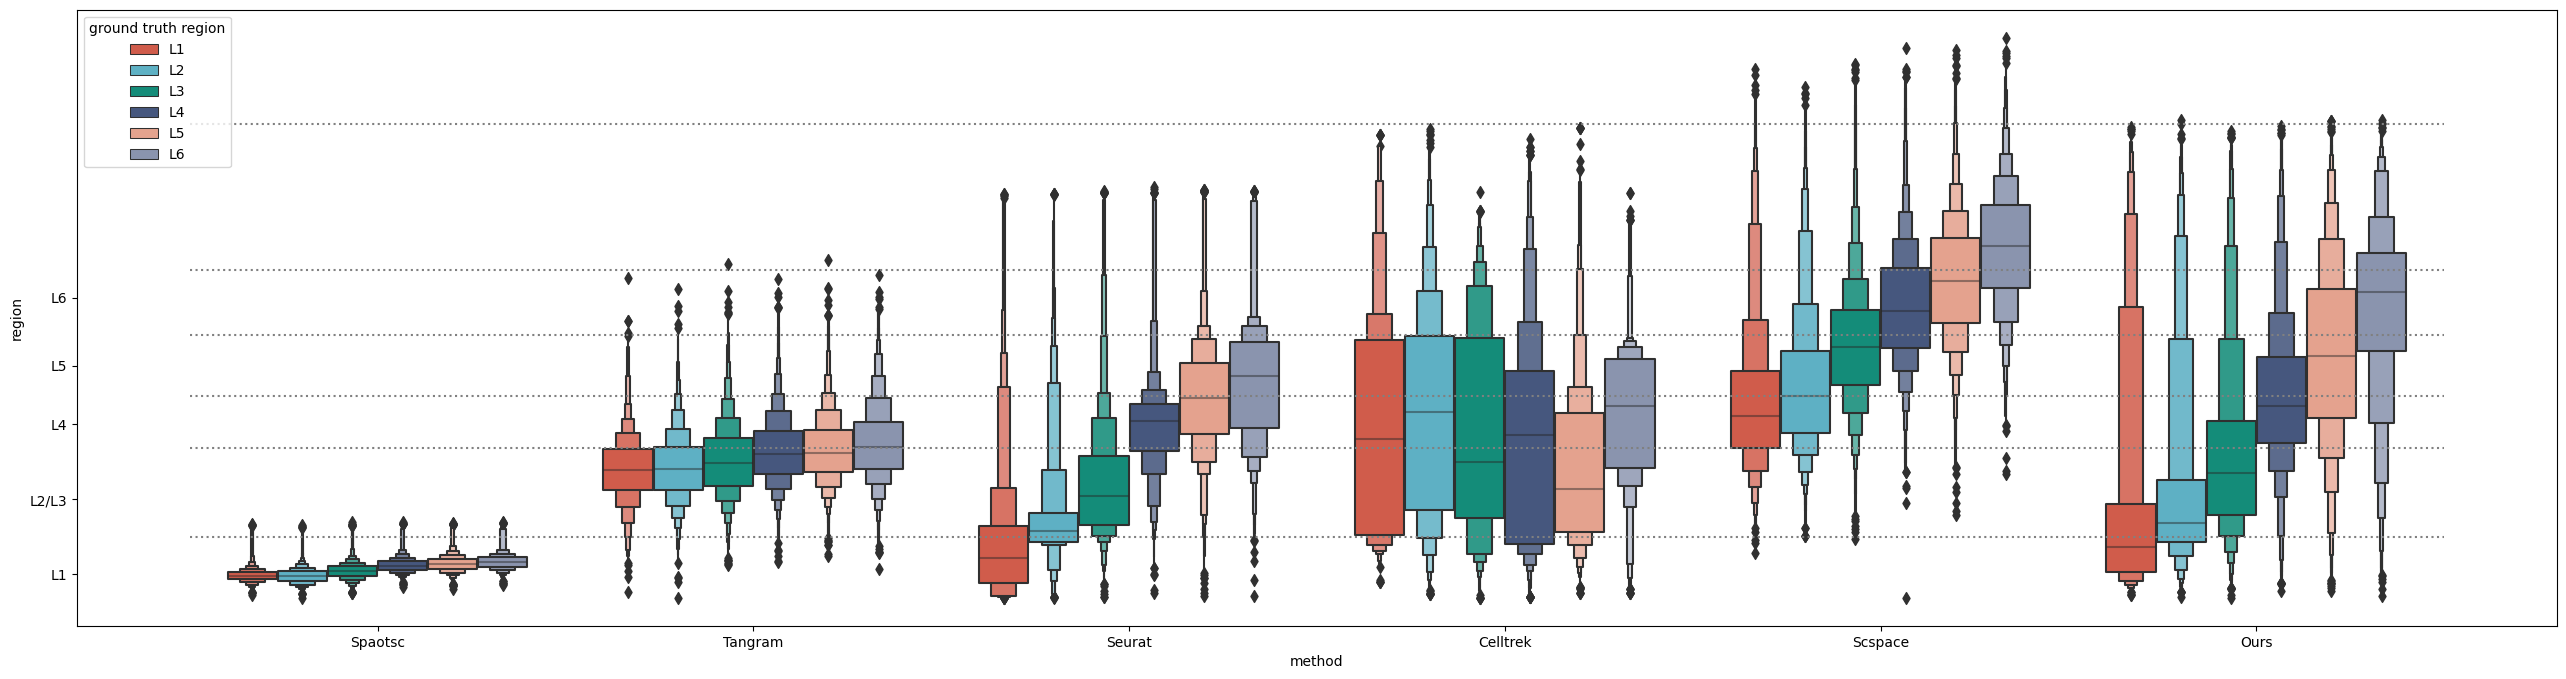

In [72]:
figsize(32,8)
ax = sns.boxenplot(data = dis_boxplot,x='method', y='dis',hue='region', hue_order=["L1","L2","L3","L4","L5","L6"], order=["Spaotsc","Tangram","Seurat","Celltrek","Scspace","Ours"])

sns.lineplot(np.linspace(-0.5, 5.5, 50), [1300]*50, linestyle=':',color='gray')
sns.lineplot(np.linspace(-0.5, 5.5, 50), [3200]*50, linestyle=':',color='gray')
sns.lineplot(np.linspace(-0.5, 5.5, 50), [4300]*50, linestyle=':',color='gray')
sns.lineplot(np.linspace(-0.5, 5.5, 50), [5600]*50, linestyle=':',color='gray')
sns.lineplot(np.linspace(-0.5, 5.5, 50), [7000]*50, linestyle=':',color='gray')
sns.lineplot(np.linspace(-0.5, 5.5, 50), [10113]*50, linestyle=':',color='gray')
ax.set_yticks([500, 2100,3700,4950,6400])
ax.set_yticklabels(["L1","L2/L3","L4","L5","L6"])
plt.ylabel('region');
ax.legend(title='ground truth region',loc='upper left')
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
plt.savefig('result_cortical/distance.pdf',bbox_inches='tight',dpi=330)